In [13]:
# Load the python modules.
import os, sys
from dapper import Chronology
#Insert the common folder in the path (to be able to load python module)
sys.path.insert(0,os.path.join(os.path.pardir,'common'))
from toolbox import load_config, path, get_filenames, load_data, get_params

from l2s_utils import plot_L96_2D, default_param

Initializing DAPPER...

but is not supported by current backend: module://ipykernel.pylab.backend_inline.
Try another backend in your settings, e.g., mpl.use('Qt5Agg').
...Done
PS: Turn off this message in your configuration: dpr_config.ini


# Setting

## Source of the data
The variable ```source``` can be set to ```"ftp"``` or ```"local"```.
- ```ftp```: it will download the data from an ftp server, so there is no need to compute the data. WARNING: it will override existing data in the data simulations data directory.
- ```local```: it will load the data locally. So you have to first either having downloaded the data from the ftp server, either having computing the data using the other notebooks.

## Configuration files
There are 4 configuration file to set. Default configuration files are provided but if you want to make further experiment, it is possible to change the configuration file.
- ```config_path```: contains all the paths where to load and save the data.
- ```config_ftp```: contains the url of the data in the ftp server. This configuration file is optional if you don't download the data from ftp.
- ```config_ref```: contains the reference simulations settings.
- ```config_sens```: contains the different settings for an sensitivity experiment.

In [32]:
#Source of the data (comment/uncomment the lines given your choice)
#source = 'local'
source = 'ftp'


In [3]:
#Configuration files
config_path = 'config/paths.yml'
config_ftp = 'config/ftp.yml' #optional if data are generated locally
config_ref = 'config/ref.yml'
config_sens = 'config/sens.yml'

In [4]:
# Load the paths (yml file)
paths = load_config('config/paths.yml')

# Rootdir for the L2S data
rootdir = path(paths['rootdir'])

#Check if figdir exist and set the figdir accordingly
savefig = 'figdir' in paths and bool(paths['figdir'])
figdir = path(os.path.join(rootdir,paths['figdir'])) if savefig else None

#Directory containing the simulations
testdir = path(os.path.join(rootdir,paths['testdir']))

#Print:
print("Directory containing the simulations:\n->",testdir)
if figdir:
    print("Directory to save the figures:\n->",figdir)

Directory containing the simulations:
-> /Users/brajard/Documents/recherche/papers/2020/PHILTRA/reddaml/data/L2S/simul/test
Directory to save the figures:
-> /Users/brajard/Documents/recherche/papers/2020/PHILTRA/reddaml/data/L2S/fig


In [34]:
#Load the ftp configuration file if needed
if source == 'ftp':
    ftp = load_config(config_ftp)
    print('\033[93m'+'Warning! The source is set to ftp. \nIt will override existing local simulation in the simulation directory'+'\033[0m')
else:
    ftp = None

Warning! The source is set to ftp. 
It will override existing local simulation in the simulation directory


## Plot Figure 1

In [35]:
# Define the reference experiment to plot
ref = load_config(config_ref)
print('Parameters of the reference experiment:\n',ref['params'])
print('Template names used to load the reference experiment:\n',ref['files'])

Parameters of the reference experiment:
 {'p': [36], 'dtObs': [0.05], 'std_o': [0.1], 'Nfil_train': [1], 'T': [15]}
Template names used to load the reference experiment:
 {'truth': 'simul-truth-T{T}-N{N}-seed{seed}.npz', 'hybrid': 'simul-hybrid-p{p}-dtObs{dtObs}-std_o{std_o}-filter{Nfil_train}-N{N}-seed{seed}.npz'}


In [36]:
# Load the data of the hybrid run
filename = get_filenames(ref, default_param=default_param)

#Check if there is exactly one filename to load
assert len(filename['hybrid']) == 1



if source == 'ftp':
    ftpurl, ftpdir = ftp['url'], ftp['test']
else:
    ftpurl, ftpdir = None, None

#Set the filename (as a str) of the data
fname = str(filename['truth'].name.iloc[0])
data_truth = load_data(testdir,fname,ftpurl=ftpurl,ftpdir=ftpdir)

print("Data file truth:\n->",fname)

fname = str(filename['hybrid'].name.iloc[0])
data_hybrid = load_data(testdir,fname,ftpurl=ftpurl,ftpdir=ftpdir)

print("Data file hybrid:\n->",fname)

ftp://ftp.nersc.no/reddaml/L2S/simul/test/simul-truth-T15-N20-seed10.npz
Data file truth:
-> simul-truth-T15-N20-seed10.npz
ftp://ftp.nersc.no/reddaml/L2S/simul/test/simul-hybrid-p36-dtObs0.05-std_o0.1-filter1-N20-seed10.npz
Data file hybrid:
-> simul-hybrid-p36-dtObs0.05-std_o0.1-filter1-N20-seed10.npz


In [37]:
# Set the time axis
all_params = get_params(ref['params'],default_param=default_param)
# There should be only one set of parameter:
assert len(all_params)==1

param = all_params[0]



{'p': [36], 'dtObs': [0.05], 'std_o': [0.1], 'Nfil_train': [1], 'T': [15]}
<sklearn.model_selection._search.ParameterGrid object at 0x11b956490> 1


In [43]:
# Format the data (the time step of the hybrid model is different from the time step of the real model)
chrono_hybrid = Chronology(dkObs=1,T=data_hybrid['T'],dt=data_hybrid['dt'])
chrono_truth = Chronology(dkObs=1,T=data_truth['T'],dt=data_truth['dt'])

#Compute the time step subsample:
dk = int(chrono_hybrid.dt/chrono_truth.dt)

#Compute the size of the hybrid model stat:
nU = xx_hybrid.shape[-1]

#Subsampe the true model in space and time to fit the hybrid model space
xx_truth = data_truth['xx'][::dk,:,:nU]
xx_hybrid = data_hybrid['xx']

#Define the time axis
tt = chrono_hybrid.tt

#Display the size of the model simulations
print('Size of the time axis:',tt.shape)
print('Size of the truth simulation (time step, members, space):',xx_truth.shape)
print('Size of the hybrid simulation (time step, members, space):',xx_hybrid.shape)

Size of the time axis: (1501,)
Size of the truth simulation (time step, members, space): (1501, 20, 36)
Size of the hybrid simulation (time step, members, space): (1501, 20, 36)


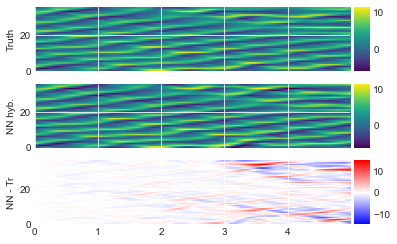

In [46]:
# Plot the figure 1

#Ensemble member to plot:
iens=1

#Number of time steps to plot
limT = 500

#Plot
fig = plot_L96_2D(xx_truth[:limT,iens],xx_hybrid[:limT,iens],tt[:limT],['Truth','NN hyb.'])

#Save (if needed)
fig.savefig(os.path.join(figdir,'philtra-fig1.png'),
            dpi=200, bbox_inches='tight', pad_inches=0)

## Plot Figure 2

In [ ]:
# Define the sensitivity figure
# sens.yml

In [ ]:
# Plot & save

In [ ]:
len(3)